# Task 3: Classification

In [1]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from my_model_selection import grid_search_kfold_cv, evaluate_model

## 3.1 Classification with all features available

Our first approach is to use all the features available in the original dataset, and those we created in the previous task from those features.

In particular we can use `n_injured`, `n_unharmed` and `n_arrested` to predict `n_killed`. We can also use `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females` to predict `n_killed`.

### 3.1.1 Preparing data for classification

In [2]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)
df_orig = pd.read_csv('../dataset_preparation/original_features.csv', index_col=0)

In [4]:
df_incidents_prepared=df_incidents_prepared.join(df_orig)
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 16

Now, `incidents_prepared` is the whole dataset with both original features and features created by us.
We decided to use only the original features for what concerns the gender and age groups of the participants: we kept `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females`. We dropped `n_participants_male` because it is highly correlated with `n_participants`.

In [5]:
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [6]:
cols2drop=[
            #categorical features difficult to encode
           'address', 'city_or_county','congressional_district','date','state', 'year_month',
           'avg_age_participants', # we already have age_group
           'n_killed',  #label
           'incident_characteristics1', # too similar to the label isKilled
           'severity', 'severity_cat', # created from n_killed

           # we decided to use original features n_females, n_injured etc. all those features are highly correlated. We decided to keep the original features because they are more interpretable
           'killed_by_district','injured_by_district', 'dfm_district_killed','dfm_district_injured', 'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen', 'dfm_district_females', 'arrested_ratio', 'unharmed_ratio', 'severity_minor',

           # correlated with n_participants
            'n_participants_adult'
            ]
df_incidents_prepared=df_incidents_prepared.drop(cols2drop, axis=1)

In [7]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   age_group               161550 non-null  object 
 4   povertyPercentage       161550 non-null  float64
 5   population              161550 non-null  int64  
 6   party                   161550 non-null  object 
 7   candidatevotes          161550 non-null  float64
 8   right_or_left           161550 non-null  float64
 9   voters_over_population  161550 non-null  float64
 10  n_arrested              161550 non-null  float64
 11  n_participants          161550 non-null  float64
 12  n_participants_teen     161550 non-null  float64
 13  n_participants_child    161550 non-null  float64
 14  n_females           

In [8]:
X=df_incidents_prepared.drop('isKilled', axis=1)
y=df_incidents_prepared['isKilled']

In [9]:
X.head()

,latitude,longitude,year,age_group,povertyPercentage,population,party,candidatevotes,right_or_left,voters_over_population,n_arrested,n_participants,n_participants_teen,n_participants_child,n_females,n_males,n_injured,n_unharmed
0,39.8322,-86.2492,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0
1,39.7745,-86.1166,2015.0,[25-34],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
2,39.7759,-86.2940,2015.0,[35-44],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
3,39.8040,-86.0095,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0
4,39.7882,-86.2091,2015.0,[45-54],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0


One Hot Encoding of categorical features

In [10]:
import pandas as pd
X=pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_arrested              161550 non-null  float64
 9   n_participants          161550 non-null  float64
 10  n_participants_teen     161550 non-null  float64
 11  n_participants_child    161550 non-null  float64
 12  n_females               161550 non-null  float64
 13  n_males                 161550 non-null  float64
 14  n_injured           

### 3.1.2 Splitting data into train and test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 3.1.3 Logistic Regression

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [13]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [14]:
# fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [15]:
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

In [16]:
# metrics
results_logreg = evaluate_model(logreg, X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy on training set:  0.9764159702878366
confusion_matrix on training set: 
 [[90595  2310]
 [  738 35597]]
Accuracy on validation set:  0.9776539770968741
Confusion matrix: 
 [[22685   541]
 [  181  8903]]
Classification report: 
               precision    recall  f1-score   support

       False       0.99      0.98      0.98     23226
        True       0.94      0.98      0.96      9084

    accuracy                           0.98     32310
   macro avg       0.97      0.98      0.97     32310
weighted avg       0.98      0.98      0.98     32310



<Axes: >

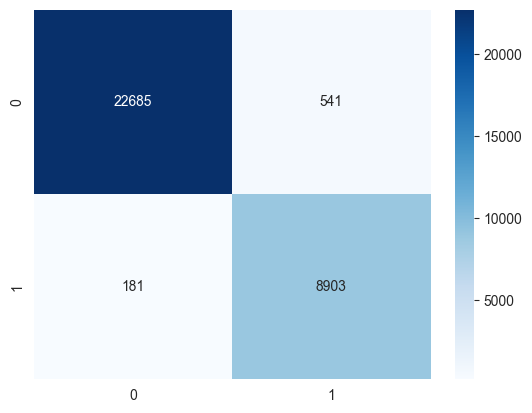

In [17]:
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

### Decision tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
best_param_dt, best_tree, results_dt = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Accuracy on training set:  0.9879294336118849
confusion_matrix on training set: 
 [[92058   847]
 [  713 35622]]
Accuracy on validation set:  0.978149179820489
Confusion matrix: 
 [[22859   367]
 [  339  8745]]
Classification report: 
               precision    recall  f1-score   support

       False       0.99      0.98      0.98     23226
        True       0.96      0.96      0.96      9084

    accuracy                           0.98     32310
   macro avg       0.97      0.97      0.97     32310
weighted avg       0.98      0.98      0.98     32310



### K-nearest neighbors


In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# grid search
accuracy_scores = []
f1_scores =[]
for i in tqdm(range(1, 10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

100%|██████████| 9/9 [01:41<00:00, 11.30s/it]


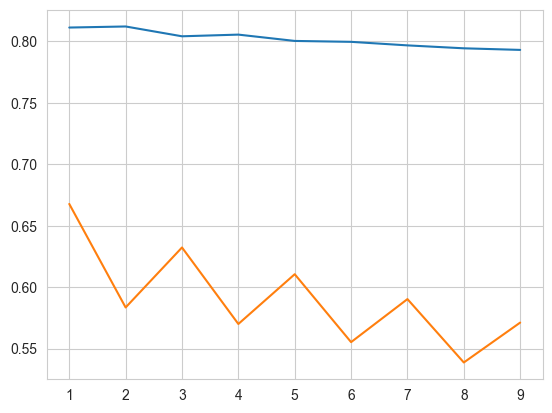

In [22]:
plt.plot(range(1, 10), accuracy_scores)
plt.plot(range(1, 10), f1_scores)

### Discussion

We can see that the arguably simpler model of them all is almost perfect, with an accuracy of $97.8\%$ on the test set, and a F1-score of $0.97$.
Our hypothesis is that the task is almost linear due to the fact that we have the features `n_injured` and `n_unharmed`. While those two features are not directly correlated to the label, it's easy to understand that $ n_{killed} \approx n_{participants}- n_{injured}- n_{unharmed} -n_{arrested}$        in the majority of cases.

We can verify our hypothesis by looking at the weights of the model:

In [23]:
for feature, weight in zip(X.columns, logreg.coef_[0]):
    print(feature, weight)

latitude -0.25124512786869685
longitude -0.13040202157530473
year 0.1283046129092459
povertyPercentage -0.12676654016593625
population -0.05025305344812988
candidatevotes -0.0005995221194863229
right_or_left -0.11980699244902059
voters_over_population -0.11692770999880574
n_arrested -6.15593309302245
n_participants 6.468147365022189
n_participants_teen 0.12357442760426762
n_participants_child 0.08677346773359136
n_females 0.7730949225546132
n_males 1.707187146907592
n_injured -5.472209128545939
n_unharmed -6.485716478011078
age_group_[0-11] -0.10603199934586036
age_group_[12-17] -0.17925186895512008
age_group_[18-24] -0.04170864107591622
age_group_[25-34] 0.04768282902528395
age_group_[35-44] 0.08920300558248082
age_group_[45-54] 0.037578045018967374
age_group_[55-64] 0.05641123432518574
age_group_[65-74] 0.008325213194440679
age_group_[75-100] 0.010692710057670833
party_DEMOCRAT 0.011134922449219741
party_REPUBLICAN -0.011134922449219741


We see that the order of magnitude of the weights is between $O(1)$ and $O(10)$, for the aforementioned features, while is smaller ($O(10^{-1})$ to $O(10^{-3})$) for almost all the other. This means that the leading computation is $n_{participants}- n_{injured} - n_{unharmed} - n_{arrested}$.

For this reason, we decided to not use the features `n_injured`, `n_unharmed` and `n_arrested` in the following models.

## 3.2 Classification without 'n_injured', 'n_unharmed', and 'n_arrested'

We have seen that keeping those features leads to great results in classification, even with a simple model like logistic regression.
That is because `n_participants` $\approx$ `n_injured` + `n_unharmed` + `n_arrested`+ `n_killed`.
We decided to drop those features because, if the number of killed is unknown, it is reasonable that the number of injured, unharmed and arrested could also be unknown.

In [24]:
X2=X.drop(['n_injured', 'n_unharmed', 'n_arrested'], axis=1)

In [25]:
X2.head()

,latitude,longitude,year,povertyPercentage,population,candidatevotes,right_or_left,voters_over_population,n_participants,n_participants_teen,...,age_group_[12-17],age_group_[18-24],age_group_[25-34],age_group_[35-44],age_group_[45-54],age_group_[55-64],age_group_[65-74],age_group_[75-100],party_DEMOCRAT,party_REPUBLICAN
0,39.8322,-86.2492,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,39.7745,-86.1166,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,39.7759,-86.2940,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,39.8040,-86.0095,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,39.7882,-86.2091,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [26]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size=0.2, random_state=42)

### 3.2.2 Decision Trees

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### Grid search for Decision Tree Parameters

In [29]:
best_params_dt2 = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=False)

In [30]:
best_params_dt2

{'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2}

#### Finer grid search  around best parameters

In [31]:
# finer grid search around best parameters
param_grid = {'max_depth': [20, 30, 40, 50 ],
              'min_samples_split': [2,3,4],
              'criterion': ['gini']
}

best_params_dt2, best_tree2, result_dt2 = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)


Accuracy on training set:  0.9973924481584648
confusion_matrix on training set: 
 [[92888    17]
 [  320 36015]]
Accuracy on validation set:  0.6491798204890127
Confusion matrix: 
 [[17469  5757]
 [ 5578  3506]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.75      0.76     23226
        True       0.38      0.39      0.38      9084

    accuracy                           0.65     32310
   macro avg       0.57      0.57      0.57     32310
weighted avg       0.65      0.65      0.65     32310



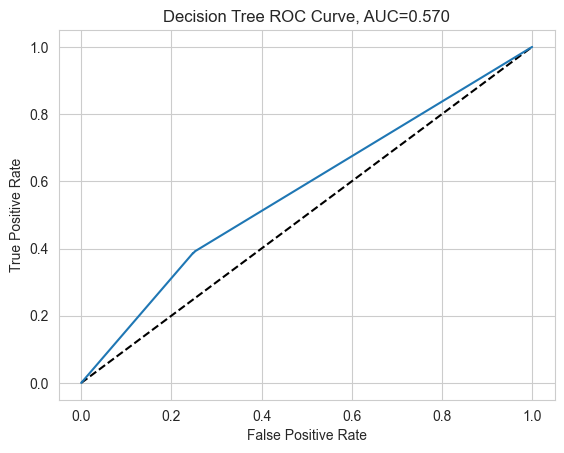

In [32]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_tree2.predict_proba(X2_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Decision Tree ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')

plt.show()


#### Try balancing data

##### Undersampling

In [33]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=41)
X2_undersampled, y_undersampled = rus.fit_resample(X2_train, y_train)
y_undersampled.value_counts()

False    36335
True     36335
Name: isKilled, dtype: int64

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1 = make_scorer(f1_score, pos_label =True)
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X2_undersampled, y_undersampled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.648 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.633 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.641 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.648 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.633 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.641 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.648 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.633 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.641 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.648 total t

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='f1', verbose=3)

In [35]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [36]:
# new grid
param_grid = {'max_depth': [4,5,6,7,8],
              'min_samples_split': [6,7,8,9,10],
              'criterion': ['gini']
}
best_param_dt_under, best_tree_under, result_dt_under = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_undersampled, y_train=y_undersampled, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Accuracy on training set:  0.6013760836658869
confusion_matrix on training set: 
 [[16633 19702]
 [ 9266 27069]]
Accuracy on validation set:  0.5338594862271743
Confusion matrix: 
 [[10548 12678]
 [ 2383  6701]]
Classification report: 
               precision    recall  f1-score   support

       False       0.82      0.45      0.58     23226
        True       0.35      0.74      0.47      9084

    accuracy                           0.53     32310
   macro avg       0.58      0.60      0.53     32310
weighted avg       0.68      0.53      0.55     32310



##### Oversampling

In [37]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X2_oversampled, y_oversampled = ros.fit_resample(X2_train, y_train)
y_oversampled.value_counts()

False    92905
True     92905
Name: isKilled, dtype: int64

In [38]:

param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
best_param_dt_over, best_tree_over, result_dt_over = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_oversampled, y_train=y_oversampled, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Accuracy on training set:  0.7498681448791776
confusion_matrix on training set: 
 [[65598 27307]
 [19170 73735]]
Accuracy on validation set:  0.6248529866914267
Confusion matrix: 
 [[14811  8415]
 [ 3706  5378]]
Classification report: 
               precision    recall  f1-score   support

       False       0.80      0.64      0.71     23226
        True       0.39      0.59      0.47      9084

    accuracy                           0.62     32310
   macro avg       0.59      0.61      0.59     32310
weighted avg       0.68      0.62      0.64     32310



In [39]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [40]:
tree_oversampled = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=6,  criterion='gini')
tree_oversampled.fit(X2_oversampled, y_oversampled)

DecisionTreeClassifier(max_depth=16, min_samples_split=6, random_state=42)

In [41]:
y_pred = tree_oversampled.predict(X2_test)
y_pred_train = tree_oversampled.predict(X2_oversampled)
print('Accuracy on training set: ', accuracy_score(y_oversampled, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_oversampled, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.7467628222377698
confusion_matrix on training set: 
 [[65364 27541]
 [19513 73392]]
Accuracy on validation set:  0.623800680903745
Confusion matrix: 
 [[14809  8417]
 [ 3738  5346]]
Classification report: 
               precision    recall  f1-score   support

       False       0.80      0.64      0.71     23226
        True       0.39      0.59      0.47      9084

    accuracy                           0.62     32310
   macro avg       0.59      0.61      0.59     32310
weighted avg       0.68      0.62      0.64     32310



##### SMOTE

### 3.2.3 KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [43]:
# train model
accuracy_scores = []
f1_scores =[]
for i in tqdm(range(1, 10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X2_train, y_train)
    y_pred = knn.predict(X2_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

100%|██████████| 9/9 [01:13<00:00,  8.20s/it]


Text(0.5, 1.0, 'accuracy and f1-score for different k values')

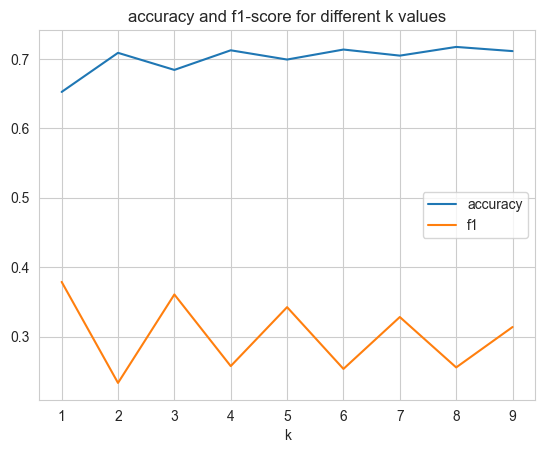

In [44]:
plt.plot(range(1, 10), accuracy_scores)
plt.plot(range(1, 10), f1_scores)
plt.xlabel('k')
plt.legend(['accuracy' ,'f1'])
plt.title('accuracy and f1-score for different k values')



In [45]:
# train again with best k
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X2_train, y_train)
y_pred = knn.predict(X2_test)
y_pred_train = knn.predict(X2_train)
print('Accuracy on training set: ', accuracy_score(y_pred_train, y_train))
print('Confusion matrix on training set: ', confusion_matrix(y_pred_train, y_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.7772670999690499
Confusion matrix on training set:  [[85102 20983]
 [ 7803 15352]]
Accuracy on test set:  0.6988238935314144
Confusion matrix: 
 [[20046  3180]
 [ 6551  2533]]
Classification report: 
               precision    recall  f1-score   support

       False       0.75      0.86      0.80     23226
        True       0.44      0.28      0.34      9084

    accuracy                           0.70     32310
   macro avg       0.60      0.57      0.57     32310
weighted avg       0.67      0.70      0.67     32310



### 3.2.1 Logistic regression

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.fit_transform(X2_test)
logreg = LogisticRegression()
logreg_model = logreg.fit(X2_train_scaled, y_train)
y_pred = logreg.predict(X2_test_scaled)
y_pred_train = logreg.predict(X2_train_scaled)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.718717115444135
confusion_matrix on training set: 
 [[91286  1619]
 [34734  1601]]
Accuracy on validation set:  0.7188177034973693
Confusion matrix: 
 [[22832   394]
 [ 8691   393]]
Classification report: 
               precision    recall  f1-score   support

       False       0.72      0.98      0.83     23226
        True       0.50      0.04      0.08      9084

    accuracy                           0.72     32310
   macro avg       0.61      0.51      0.46     32310
weighted avg       0.66      0.72      0.62     32310



In [48]:
# weights of model
for i in zip(X2.columns, logreg_model.coef_[0]):
    print(i)

('latitude', -0.2279061259152831)
('longitude', -0.1565044988927179)
('year', 0.010174639566654127)
('povertyPercentage', -0.002259700209580947)
('population', -0.046952870326052214)
('candidatevotes', 0.010518710146572728)
('right_or_left', -0.12164973902830302)
('voters_over_population', -0.15400009927258154)
('n_participants', -0.13222351307693353)
('n_participants_teen', 0.041457141296639355)
('n_participants_child', 0.05030380425126665)
('n_females', 0.18559036699301174)
('n_males', 0.31285555852397984)
('age_group_[0-11]', -0.09322618633001725)
('age_group_[12-17]', -0.17940536712787186)
('age_group_[18-24]', -0.0810596244378866)
('age_group_[25-34]', 0.029808795203353243)
('age_group_[35-44]', 0.07995762496436633)
('age_group_[45-54]', 0.10338442585716325)
('age_group_[55-64]', 0.08417443253575393)
('age_group_[65-74]', 0.04653436825285826)
('age_group_[75-100]', 0.038289465704948566)
('party_DEMOCRAT', 0.004510225288792418)
('party_REPUBLICAN', -0.004510225288792418)


In [49]:
# correlation n_killed and n_injured
df_orig['isKilled'] = df_incidents_prepared['isKilled']
df_orig['isInjured'] = df_orig['n_injured'] > 0
df_orig['isKilled'].corr(df_orig['isInjured'])

-0.3597385293540303

### 3.2.4 Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
# grid search for random forest
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [20,30,40],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}

best_params_rf2 = grid_search_kfold_cv(model_class=RandomForestClassifier, param_grid=param_grid,
                                       X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3,metric='f1', eval=False)

In [ ]:
best_params_rf2

In [ ]:
#new gs around best parameters max_depth =16, min_samples_split=2, criterion='gini', n_estimators=50
param_grid_rf2 = {'max_depth': [16, 18, 20],
              'min_samples_split': [ 2, 3, 4],
              'criterion': ['gini'],
              'n_estimators': [ 50, 60, 70]
}
best_params_rf2, best_rf2, result_rf2 = grid_search_kfold_cv(model_class=RandomForestClassifier,
                                                             param_grid=param_grid_rf2,X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

## 3.3 Classification using n_injured and n_participants

In [ ]:
X3=df_incidents_prepared.drop('isKilled', axis=1)

In [ ]:
X3.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)

In [ ]:
X3.head()

In [ ]:
# one hot encoding
X3=pd.get_dummies(X3)

In [ ]:
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

### Decision Tree

In [ ]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}

best_params_dt3, best_tree3, result_dt3 = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X3_train, y_train=y_train, X_test=X3_test, y_test=y_test,  cv=3, metric='f1', eval=True)

### Random Forest

In [ ]:
# grid search

param_grid_rf = {'max_depth': [4, 8, 16],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}

best_params_rf3, best_rf3, result_rf3 = grid_search_kfold_cv(model_class=RandomForestClassifier,
                                                            param_grid=param_grid_rf, X_train=X3_train, y_train=y_train, X_test=X3_test, y_test=y_test,  cv=3,
                                                            metric='f1', eval=True)

In [ ]:
# plot confusion matrix
y_pred = best_rf3.predict(X3_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')


In [ ]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_rf3.predict_proba(X3_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'Random Forest ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')
plt.show()

### Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
scaler = StandardScaler()
X=df_incidents_prepared.drop('isKilled', axis=1)
X.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)
X=pd.get_dummies(X)
X.shape

In [ ]:

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, stratify=y_train)

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [ ]:
X.info()

In [ ]:
input_size = X_train.shape[1]

In [ ]:
model = Sequential([Dense(32, activation='relu', input_shape=(input_size, ) ),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

sampler = RandomUnderSampler(random_state=42)
X_train_scaled, y_train = sampler.fit_resample(X_train_scaled, y_train)

In [ ]:
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, callbacks=[early_stopping])

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
y_pred = y_pred > 0.5
y_pred_train = y_pred_train > 0.5
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))